<a href="https://colab.research.google.com/github/cedamusk/AI-N-ML/blob/main/Ordinal_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinal Logistic Regression

## Install mord
To run the code for Ordinal Logistic Regression, the `mord` library must be installed. This library provides tools for odinal regression, which handles problems where the target variable has a natural order but no consistent difference between categories.

In [ ]:
!pip install mord

## Import libraries
`numpy`: Provides support for numerical operations and handling arrays effeciently. It's commonly used for numerical computations.

`pandas`: A library for data manipulation and analysis, particularly useful for handling tabular data with its `DataFrame` structure.

`make_classification`: A utility function to generate synthetic datasets for classification problems, making it easier to test and validate models.

`train_test_split`: Splits the dataset into training and testing subsets for model evaluation.

`GridSearchCV`: Performs hyperparameter tuning using cross-validation to find the best combination of parameters.

`confusion_matrix`: Creates a matrix showing true positives, true negatives, false positives, and false negatives for classification results.

`accuracy_score`: Measures the overall accuracy of the model (correct predictions/ total predictions).

`precision_score`, `recall_score`, `f1_score`: Metrics for evaluating classification performance.

  **Precision**: Ratio of true positives to all predicted positives.

  **Recall**: Ratio of true positives to all actual positives.

  **F1 Score**: Harmoic mean of precision and recall, balancing both metrics.

`StanndardScaler`: Standardizes features by removing the mean and scaling to unit variance, improving model performance by ensuring all features are on the same scale.

`Pipeline`: Simplifies the process of applying a sequence of data preprocessing steps and model training, ensuring reproducibility.

`make_scorer`: Customizes scoring functions for model evaluation, allowing you to define metrics tailored to specific objectives.

`PCA` **(Principal Component Analysis)**: A dimensionality reduction technique used to reduce the number of features while retaining as much variance as possible.

`matplotlib.pyplot`: A plotting library for creating static, interactive, and animated visualizations.

`seaborn`: A library built on top of Matplotlib, offering high-level, aesthetically pleasing statistical plots.

`LogisticIT`: An implementation of ordinal logistic regression provided by the `mord` library. It models ordinal target variables by fitting an intercept and slope for each category.

`warnings.filterwarnings('ignore')`: Suppresses warning messages to avoid cluttering the output, especially durin iterative runs or when working with experimental features.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mord import LogisticIT
import warnings
warnings.filterwarnings('ignore')

## Create Ordinal Dataset
This function generates a synthetic dataset for ordinal regression, where the target variables has an ordered, categorical structure.

`n_samples`: Number of samples (data points) to generate (defaults: 1000).

`n_features`: Number of features (predictor variables) to generate (default: 5).

`n_classes`: Number of ordianl catgeories for the target variables ( default: 3).

`class_sep`: A scaling factor to control the separation between classes (default: 2.0).

In [ ]:
def create_ordinal_dataset(n_samples=1000, n_features=5, n_classes=3, class_sep=2.0):
  X=np.random.randn(n_samples, n_features) #Generates a randome dataset of shape `(n_samples, n_features) using the standard normal distribution
  beta=np.random.randn(n_features) #Creates a random coefficient vector for features, represnting the relationship between predictors and the target variable
  z=np.dot(X, beta)
  # Computes a linear combination of features using the coefficient vector beta. This represents a contnuous latent variable (z) before mappig to ordinal categories.


  z=z-np.mean(z) #Centers the latent variable z around zero by subtracting its mean
  z=z*class_sep/np.std(z)#Scales the latent variable by the class_sep factor, which controls te spread (or separation) between categories

  thresholds=np.linspace(z.min(), z.max(), n_classes+1)[1:-1]
  """Computes evenly spaced thresholds between minimum and maxmimum values of z to define the the boundaries
  between ordinal categories

  np.linspace: Generates n_classes+1 equally spaced values.

  [1:-1]: Selects the inner thresholds, leaving out the extreme edges.

  """
  y=np.zeros(n_samples, dtype=int) #Initializes the target variable y as an array of zeros, representing the base category
  for i, threshold in enumerate(thresholds):
    y[z> threshold] =i+1

#Loops through the the thresholds, assigning ordinal categories to y based on the values of z. Each threshold separates z into a higher category.

  return X, y

## Custom adjacency scorer
This function computes a custom scoring metric to evaluate the performance of an ordinal regression model. The metric checks how often the predicted ordinal category is within one adjacent level of the true label.

### Key insights


1.   **Metric type**: The metric is less strict than exact accuracy and is designed for ordinal problems where being close to the true value is acceptable.
2.   **Use case**: Particularly useful in ordinal classification tasks where small deviations from the true label are tolerable.

3.   **Interpretation**: A score of `1.0` indicates perfect adjacency (all predictions are within +/- of the true labels). Lower scores suggest that many predictions are far from the true labels.



In [ ]:
def custom_adjacency_scorer(y_true, y_pred):

  """
  Compute a custom adjacency score for ordinal regression.

  Parameters:
  y_true: Array-like of shape (n_samples,)
    The True Ordinal Labels.
  y_pred: array-like of shape (n_samples,)
    The predicted ordinal labels

  Returns:
  float: The proportion of predictions that are within one level of the true labels.

  Description:

  The adjacency scoe evaluates the performance of ordinal regression allowing a tolerance of +/-1 between
  the predicted label (`y_pred`) and the true label (`y_true`). This is useful for ordinal problems where predictions
  close to the true value are still considered

  Formula:
  -For each sample, calculate `|y_true-y_pred|`
  -If the difference is <= 1, consider the prediction correct.
  -Compute the mean of all such correct predictions.

  Example:
  >>>>y_true=[2, 3, 4, 3]
  >>>>y_pred=[3, 3, 5, 2]
  >>>>custom_adjacency_scorer(y_true, y_pred)
  1.0 #All predictions are within +/-1 of the true labels.
  """
  return np.mean(np.abs(y_true-y_pred) <= 1)

## Dataset generation
This code uses the `create_ordinal_dataset` function to generate a synthetic dataset for ordinal logistic regression.

### Output


*   `X`: A NumPy array of shape `(1000, 5)` representing the feature matrix.
*   `y`: A NumPy array of shape `(1000, )` representing the ordinal target variable, with values in `{0, 1, 2}`

### Use case
This datasets is used to simulate ordinal regression scenarios, where the target variabl `y` represents ordered categoried. For examples:

*    Severity levels of a condition
*    Satisfaction ratings.



In [ ]:
X, y=create_ordinal_dataset(
    n_samples=1000,#Generates 1,000 data samples (rows)
    n_features=5, #Each sample will have 5 features (columns)
    n_classes=3, #The target variable `y` will have 3 ordinal classes (e.g., 0, 1, 2)
    class_sep=2.0 #Specifies the separation between classes, where larger values make class boundaries more distinct
)

## Pipeline creation
The following code defines a pipeline for processing data and training The model. The pipeline ensures that data preprocessing and model fitting occur sequentially and effeciently.

A tool from `sklearn.pipeline.Pipeline` that allows chaining multiple data preprocessing and modelling steps into one object. It ensures the reproducibility and simplifies the code.

### Use case
This pipeline is designed for ordinal regression tasks where the target variable has a natural order. It automates preprocessing and modelling, ensuring all steps occur in the correct sequence.

### Key advantages
* **Scalability**: The pipeline can handle scaling, dimensionality reduction, and modelling for larger datasets.
* **Reproducibility**: It standardizes the workflow, making it easier to debug and share code.
* **Efficiency**: Integrates preprocessing and model training, eliminating manual steps.

In [ ]:
pipeline=Pipeline([
    ('scaler', StandardScaler()), #Scales the features to have zero mean and unit variance.
    #Ensures that features are standardized, which is crucial for PCA and LogisticIT to perform optimally.

    ('pca', PCA(n_components=4)), #Performs Principal Component Analysis to reduce the dimensioality of the dataset
    #The dataset feature space is reduced to 4 components, capturing the most variance while discarding less informative features.

    ('ordinal', LogisticIT())#Fits the LogisticIT model from the `mord` library
    #LogisticIT performs ordinal logistic regression, predicting ordered categories
])

## Parameter grid for hypeparameter tuning
The following code snippet defines a parameter grid ofr tuning the `LogisticIT` model's hyperparameter within the pipeline using `GridSearchCV`.

1. `param_grid`: A dictionary that specifies hyperparamters to tune and their respective values for the `LogisticIT` model.

2. **Parameter being tuned
`ordinal_alpha`**: Refers to the regularization parameter (`alpha`) in the `LogisticIT` model.

* Controls the strength of regularization in the model.

* Smaller values (e.g., 0.001) correspond to weaker regularization.

* Larger values (e.g., 1.0) correspond to stronger regularization, which can prevent overfitting by penalizing large coefficients.

3. **`ordinal__`Prefix**

* Refers to the `LogisticIT` step in the pipeline.

* The prefix follows the `Pipeline` convention, where the stape name (`ordinal`) is prepended to the parameter name (`alpha`) using the double underscores (`__`).


###Purpose
* The grid defines a range of `alpha` values to find the optimal regularization strength for the model.

* Helps improve the model's performance by balancing bias and variance through cross-validation.

In [ ]:
param_grid={
    'ordinal__alpha': [0.001, 0.01, 0.1, 1.0]
}

## Train-Test split
This code splits the dataset into training and testing subsets, ensuring the distribution of he target variable (`y`) is preserved across both sets.

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
grid_search=GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'adjacency': make_scorer(custom_adjacency_scorer)
    },
    refit='adjacency',
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_

In [ ]:
y_pred=best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)

In [ ]:
conf_matrix=confusion_matrix(y_test, y_pred)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred, average='weighted')
recall=recall_score(y_test, y_pred, average='weighted')
f1=f1_score(y_test, y_pred, average='weighted')

In [ ]:
print("\nBest Model Parameters:")
print(grid_search.best_params_)


Best Model Parameters:
{'ordinal__alpha': 0.001}


In [ ]:
print("\nCross-validation results:")
for metric, scores in grid_search.cv_results_.items():
  if metric.startswith('mean_test'):
    print(f"{metric}:{scores[grid_search.best_index_]:.4f}")


Cross-validation results:
mean_test_accuracy:0.8300
mean_test_adjacency:1.0000


In [ ]:
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Model Evaluation Metrics:
Accuracy: 0.8150
Precision: 0.8170
Recall: 0.8150
F1 Score: 0.8158


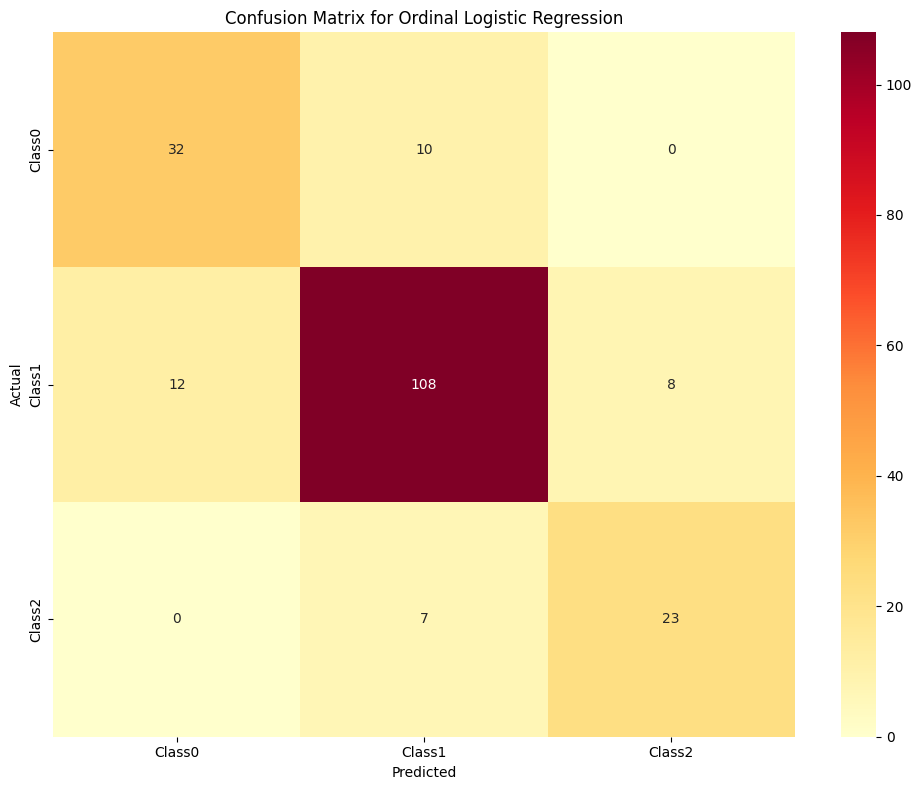

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[f'Class{i}' for i in range(3)],
            yticklabels=[f'Class{i}' for i in range(3)])
plt.title('Confusion Matrix for Ordinal Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

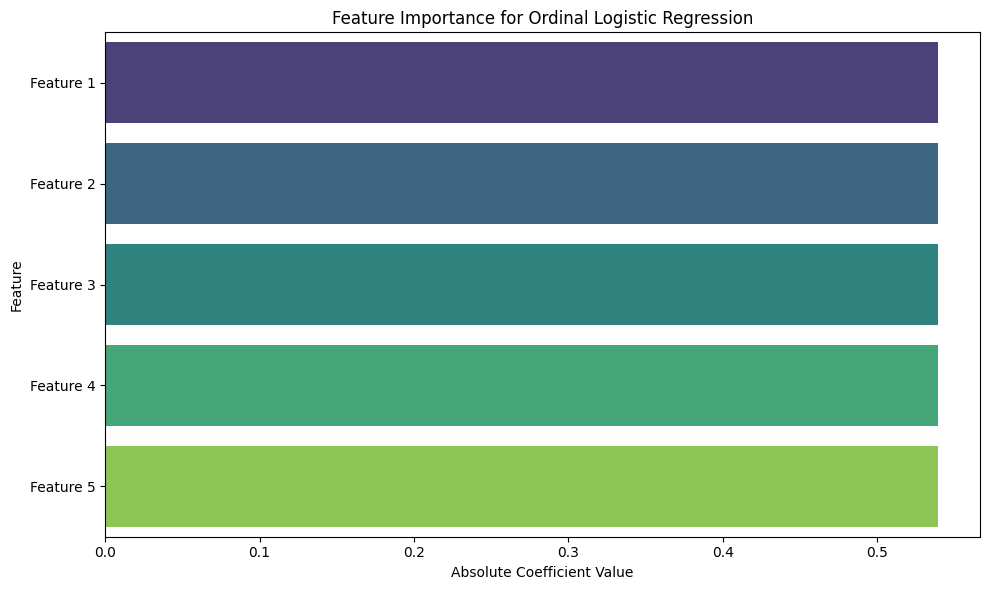

In [ ]:
feature_importance=pd.DataFrame({
    'Feature':[f'Feature {i+1}' for i in range(5)],
    'Coefficient': np.abs(best_model.named_steps['ordinal'].coef_[0])
})
feature_importance=feature_importance.sort_values('Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance for Ordinal Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

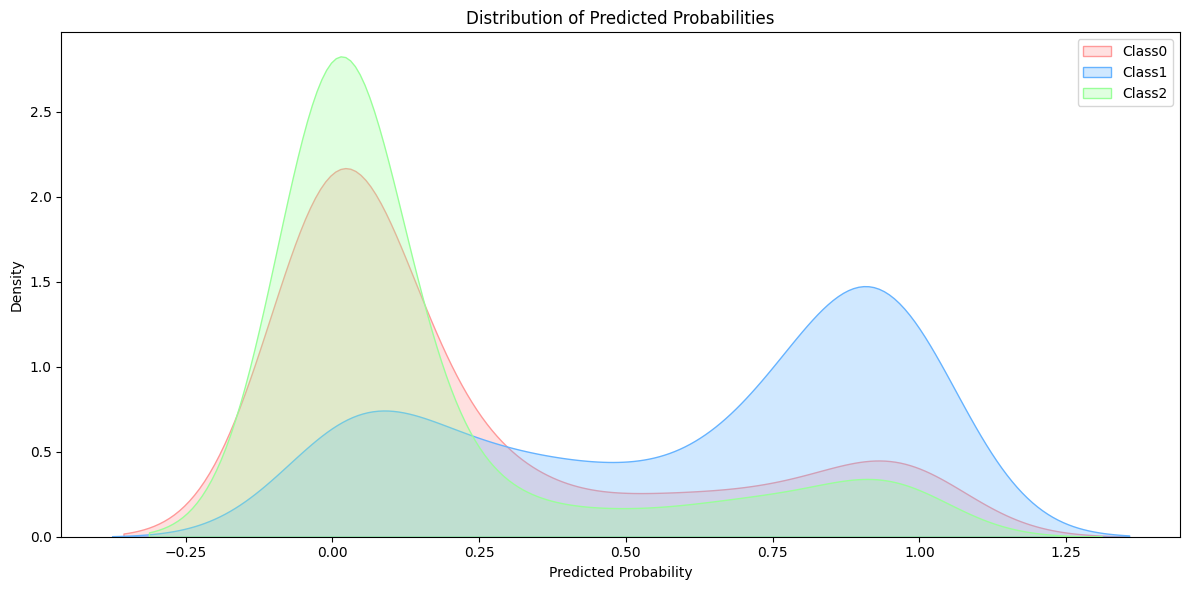

In [ ]:
plt.figure(figsize=(12, 6))
colors=['#ff9999', '#66b3ff', '#99ff99']
for i in range(3):
  sns.kdeplot(y_pred_proba[:, i], label=f'Class{i}', color=colors[i], fill=True, alpha=0.3)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("\nClass-specific Metrics:")
for i in range(3):
  class_mask=y_test==i
  class_precision=precision_score(y_test==i, y_pred==i, zero_division=0)
  class_recall=recall_score(y_test==i, y_pred==i, labels=[i], zero_division=0)
  class_f1=f1_score(y_test==i, y_pred==i, zero_division=0)

  print(f"\nClass{i}:")
  print(f"\nClass in test set: {sum(class_mask)}")
  print(f"Precision: {class_precision:.4f}")
  print(f"Recall: {class_recall:.4f}")
  print(f"F1 Score: {class_f1:.4f}")


Class-specific Metrics:

Class0:

Class in test set: 42
Precision: 0.7273
Recall: 0.7619
F1 Score: 0.7442

Class1:

Class in test set: 128
Precision: 0.8640
Recall: 0.8438
F1 Score: 0.8538

Class2:

Class in test set: 30
Precision: 0.7419
Recall: 0.7667
F1 Score: 0.7541


In [ ]:
adjacent_accuracy=np.mean(np.abs(y_test-y_pred)<=1)
print(f"\nadjacency Accuracy: {adjacent_accuracy:.4f}")


adjacency Accuracy: 1.0000


In [ ]:
mae=np.mean(np.abs(y_test-y_pred))
mse=np.mean((y_test-y_pred)**2)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Mean Absolute Error: 0.1850
Mean Squared Error: 0.1850


In [ ]:
print("\nClass Distribution:")
print("Training Set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_train==i):.2f}")
print("\nTest set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_test==i):.2%}")


Class Distribution:
Training Set:
Class 0: 0.21
Class 1: 0.64
Class 2: 0.15

Test set:
Class 0: 21.00%
Class 1: 64.00%
Class 2: 15.00%
